<a href="https://colab.research.google.com/github/dnezan/km-sku-prediction/blob/main/KM_forecast_main_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **KwickMetrics Forecast Practice**
Dinesh Sreekanthan<br>
https://github.com/dnezan/km-sku-prediction

# Data Overview
The dataset has 3 columns
<br>
*   SKU ID
*   Date
*   Number of items sold that day

By using the function `=COUNTUNIQUE(A:A)` in Google Spreadsheets or `Dataframe.unique()` in Pandas, we can find the number of unique items being sold. <br>

**There are 3 unique items being sold over a period of about 67 months (2016-05-08 - 2021-12-06)**

# Setting up Cloud Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd "/content/drive/My Drive"

/content/drive/My Drive


In [7]:
!mkdir km-forecast-practice

mkdir: cannot create directory ‘km-forecast-practice’: File exists


In [8]:
%cd "/content/drive/My Drive/km-forecast-practice"

/content/drive/My Drive/km-forecast-practice


Make sure to move your dataset `km-forecast-practice.csv` to this folder.

In [9]:
!ls

'=4.0.0'
 amazon.com-2016-masked.csv
 amazon.com-2016-masked-datef.csv
 daily_data_processed.csv
 dataset-day-wise-amazon.com-masked2.csv
 dataset-day-wise-amazon.com-masked.gsheet
 dataset_new.csv
 dataset_new.gsheet
 fig.png
 frame_folder
 graph2.png
 graph3.png
 graph.svg
 graph_total.svg
 km-forecast-practice-data.csv
 my_awesome.gif
 OLDdataset-day-wise-amazon.com-masked.csv
 OLD_km-forecast-practice-data.csv
 requirements.txt
 results_1.gif
 results_2.gif
 results_3.gif
 results_4.gif
 results_5.gif
 results_6.gif
 temppp.csv
 traindate.csv
 traindate_z.csv


In [10]:
import pandas as pd
import csv
import datetime

dataset_name = 'dataset-day-wise-amazon.com-masked2.csv'
df=pd.read_csv(dataset_name)
df['timestamp']= pd.to_datetime(df['timestamp'])
print(df.dtypes)
df.head()

item_id               int64
timestamp    datetime64[ns]
demand                int64
dtype: object


,item_id,timestamp,demand
0,528,2016-05-08,0
1,528,2016-05-09,0
2,528,2016-05-10,0
3,528,2016-05-11,1
4,528,2016-05-12,2


# Preprocessing the Data
The first step is to rearrange the data so that we have each column representing a day and the rows containing the SKU ID. <br> 
We must also populate the data with missing dates, which we assume have 0 items sold on that day. So the first step is to add the missing dates, then set these as 0.

In [11]:
from dateutil.relativedelta import *

start_date=df.timestamp[0].date()  
end_date=df.timestamp.iat[-1].date()
start_sku=df.item_id[1]
print('Start date is',start_date)
print('End date is',end_date)
print("First SKU is",start_sku)

data = [[start_sku, 0]]

# Populating the new dataset with first row
df_new = pd.DataFrame(data, columns = ['SKU', start_date])
x = start_date

index = 2
var=0
num_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
num_days = (end_date-start_date).days

print("There are", num_months, "months between the two dates")
print("There are", num_days, "days between the two dates")

choice_num = input("Is your data daily or monthly? (d/m) ")
if (choice_num == 'd'):
  num_var = num_days
elif (choice_num == 'm'):
  num_var = num_months

while var<num_var:
  if (choice_num == 'd'):
    x+= datetime.timedelta(days=1)
  elif (choice_num == 'm'):
      x = x + relativedelta(months=+1)
  df_new.insert(loc=index, column=x, value=0)
  index+=1
  var+=1
year_mark = df_new
df_new.head()

Start date is 2016-05-08
End date is 2021-12-06
First SKU is 528
There are 67 months between the two dates
There are 2038 days between the two dates
Is your data daily or monthly? (d/m) d


,SKU,2016-05-08,2016-05-09,2016-05-10,2016-05-11,2016-05-12,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,2016-06-02,2016-06-03,2016-06-04,2016-06-05,2016-06-06,2016-06-07,2016-06-08,2016-06-09,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,...,2021-10-28,2021-10-29,2021-10-30,2021-10-31,2021-11-01,2021-11-02,2021-11-03,2021-11-04,2021-11-05,2021-11-06,2021-11-07,2021-11-08,2021-11-09,2021-11-10,2021-11-11,2021-11-12,2021-11-13,2021-11-14,2021-11-15,2021-11-16,2021-11-17,2021-11-18,2021-11-19,2021-11-20,2021-11-21,2021-11-22,2021-11-23,2021-11-24,2021-11-25,2021-11-26,2021-11-27,2021-11-28,2021-11-29,2021-11-30,2021-12-01,2021-12-02,2021-12-03,2021-12-04,2021-12-05,2021-12-06
0,528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we add all the unique products and populate the Dataframe with 0s. (Takes a few minutes to complete)

In [12]:
print(df_new.shape[1]) #number of columns

uniqval = list(df.item_id.unique()) #list of unique products
uniqval.pop(0)

x=0
while x < len(uniqval):
  listofzeros = [0] * (num_var + 1)
  listofzeros.insert(0, uniqval[x])
  df_length = len(df_new)
  df_new.loc[df_length] = listofzeros
  x+=1
  if(x%200==0):
    print(x)

print(df_new)

uniqval.insert(0,start_sku)

2040
    SKU  2016-05-08  2016-05-09  ...  2021-12-04  2021-12-05  2021-12-06
0   528           0           0  ...           0           0           0
1   529           0           0  ...           0           0           0
2  2336           0           0  ...           0           0           0

[3 rows x 2040 columns]


Next we fill in the values of items that were actually sold on a given day.

In [13]:
#Adding first product sales
count=-1

for y in uniqval:
  for x in df.item_id:
    if x == y: 
      count+=1
      z=df_new.columns.get_loc(pd.to_datetime(df.timestamp[count].date()).date())
      z1=df_new.index.get_loc(df_new.index[df_new['SKU'] == x][0])
      df_new.iloc[z1,z] = df.demand[count]
      
print("This product was sold on",count,"days")
df_new.head()

This product was sold on 5693 days


,SKU,2016-05-08,2016-05-09,2016-05-10,2016-05-11,2016-05-12,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,2016-06-02,2016-06-03,2016-06-04,2016-06-05,2016-06-06,2016-06-07,2016-06-08,2016-06-09,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,...,2021-10-28,2021-10-29,2021-10-30,2021-10-31,2021-11-01,2021-11-02,2021-11-03,2021-11-04,2021-11-05,2021-11-06,2021-11-07,2021-11-08,2021-11-09,2021-11-10,2021-11-11,2021-11-12,2021-11-13,2021-11-14,2021-11-15,2021-11-16,2021-11-17,2021-11-18,2021-11-19,2021-11-20,2021-11-21,2021-11-22,2021-11-23,2021-11-24,2021-11-25,2021-11-26,2021-11-27,2021-11-28,2021-11-29,2021-11-30,2021-12-01,2021-12-02,2021-12-03,2021-12-04,2021-12-05,2021-12-06
0,528,0,0,0,1,2,2,2,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14,19,15,17,16,18,21,13,18,16,10,273,352,5,25,30,37,42,17,10,19,9,21,33,23,24,18,21,20,54,52,40,123,53,23,22,34,52,46,40
1,529,1,0,0,0,2,0,1,0,2,0,1,1,0,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,5,3,8,4,5,4,3,3,3,10,28,11,8,4,7,9,6,10,7,6,9,11,5,3,12,4,6,7,16,12,23,15,5,5,4,10,3,7
2,2336,0,0,1,0,0,0,1,1,0,1,2,0,1,0,0,1,2,1,0,0,1,0,0,0,1,1,0,0,0,0,20,40,0,1,2,0,0,2,0,...,24,19,16,20,23,23,21,23,19,17,28,24,37,23,29,35,33,41,37,38,39,42,39,33,41,53,49,33,37,86,84,67,84,57,18,18,49,62,59,39


In [14]:
df_new.to_csv('dataset_new.csv')

# Visualisation
Here we can visualise the sales of the first product in our dataset over a year.


In [15]:
import numpy as np 
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


#Enter random SKU here
a=0
b=1
c=2

product_name_x = str(df_new.SKU[a])
product_name_y = str(df_new.SKU[b])
product_name_z = str(df_new.SKU[c])

sales_x = df_new.iloc[a].tolist()
del sales_x[0] #remove item_id
sales_y = df_new.iloc[b].tolist()
del sales_y[0] #remove item_id
sales_z = df_new.iloc[c].tolist()
del sales_z[0] #remove item_id
dates_list = df_new.columns.tolist()
del dates_list[0] #remove column name

df_x = pd.DataFrame(np.transpose([dates_list, sales_x]))
df_x.columns = ["ds", "y"]
df_x["ds"]= pd.to_datetime(df_x["ds"])
print("")
print(product_name_x)
print(df_x.head(6))

df_y = pd.DataFrame(np.transpose([dates_list, sales_y]))
df_y.columns = ["ds", "y"]
df_y["ds"]= pd.to_datetime(df_y["ds"])
print("")
print(product_name_y)
print(df_y.head(6))

df_z = pd.DataFrame(np.transpose([dates_list, sales_z]))
df_z.columns = ["ds", "y"]
df_z["ds"]= pd.to_datetime(df_z["ds"])
print("")
print(product_name_z)
print(df_z.head(6))

###PLOTLY
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.offline import iplot
import plotly.io as pio
pio.renderers.default='colab'

df_var = df_x

df_var['ds'] = pd.to_datetime(df_var['ds'])
weekly_df = df_var.resample('W', on='ds').apply(sum)
monthly_df = df_var.resample('M', on='ds').apply(sum)
daily_df = df_var.resample('D', on='ds').apply(sum)

colors = ["#ff3a3c", "#99c0f7", "#73e0e7", '#de5200']
fig = go.Figure()
fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Monthly Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(weekly_df.index.values), y = weekly_df['y'], mode = 'lines', line=dict(color=colors[1]), name = 'Weekly Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(daily_df.index.values), y = daily_df['y'], mode = 'lines', line=dict(color=colors[0]), name = 'Daily Sales'))
fig.update_layout(title = dict(text='Daily/Weekly/Monthly Sales for Product SKU '+product_name_x,x=0.5, font =dict(size=17, color = 'white')))
fig.update_layout(xaxis = {'title':'Year', 'color':'white'}, yaxis = {'title':'Demand', 'color':'white'}, paper_bgcolor='#1c1c28', plot_bgcolor='#28293d')
fig.update_layout(legend_font_color="white")
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')

fig.show()

##SKU 2
df_var = df_y

df_var['ds'] = pd.to_datetime(df_var['ds'])
weekly_df = df_var.resample('W', on='ds').apply(sum)
monthly_df = df_var.resample('M', on='ds').apply(sum)
daily_df = df_var.resample('D', on='ds').apply(sum)

print("")

colors = px.colors.qualitative.Plotly
fig = go.Figure()
fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Monthly Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(weekly_df.index.values), y = weekly_df['y'], mode = 'lines', line=dict(color=colors[1]), name = 'Weekly Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(daily_df.index.values), y = daily_df['y'], mode = 'lines', line=dict(color=colors[0]), name = 'Daily Sales'))
fig.update_layout(title = dict(text='Daily/Weekly/Monthly Sales for Product SKU '+product_name_y,x=0.5, font =dict(size=17, color = 'white')))
fig.update_layout(xaxis = {'title':'Year', 'color':'white'}, yaxis = {'title':'Demand', 'color':'white'}, paper_bgcolor='#1c1c28', plot_bgcolor='#28293d')
fig.update_layout(legend_font_color="white")
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')

fig.show()

##SKU3
df_var = df_z

df_var['ds'] = pd.to_datetime(df_var['ds'])
weekly_df = df_var.resample('W', on='ds').apply(sum)
monthly_df = df_var.resample('M', on='ds').apply(sum)
daily_df = df_var.resample('D', on='ds').apply(sum)

print("")

colors = px.colors.qualitative.Plotly
fig = go.Figure()
fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Monthly Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(weekly_df.index.values), y = weekly_df['y'], mode = 'lines', line=dict(color=colors[1]), name = 'Weekly Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(daily_df.index.values), y = daily_df['y'], mode = 'lines', line=dict(color=colors[0]), name = 'Daily Sales'))
fig.update_layout(title = dict(text='Daily/Weekly/Monthly Sales for Product SKU '+product_name_z,x=0.5, font =dict(size=17, color = 'white')))
fig.update_layout(xaxis = {'title':'Year', 'color':'white'}, yaxis = {'title':'Demand', 'color':'white'}, paper_bgcolor='#1c1c28', plot_bgcolor='#28293d')
fig.update_layout(legend_font_color="white")
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')

fig.show()





528
          ds  y
0 2016-05-08  0
1 2016-05-09  0
2 2016-05-10  0
3 2016-05-11  1
4 2016-05-12  2
5 2016-05-13  2

529
          ds  y
0 2016-05-08  1
1 2016-05-09  0
2 2016-05-10  0
3 2016-05-11  0
4 2016-05-12  2
5 2016-05-13  0

2336
          ds  y
0 2016-05-08  0
1 2016-05-09  0
2 2016-05-10  1
3 2016-05-11  0
4 2016-05-12  0
5 2016-05-13  0


# Wavelet Denoising 
Since the daily data is high frequency and very noisy, we can denoise the data to make it easier to understand from an analyst's perpspective.

*   DWT Denoising
*   Binning into weeks/months



# DWT denoising 
https://en.wikipedia.org/wiki/Wavelet

# **Modeling**

# Splitting Train-Validation-Test Models<br>
We can choose to train on the first 90 days of the dataset and then predict the next 30 days after that. This prediction can be validated with our validation set of 30 days after the training dataset.

In [16]:
train_range_start=0   
train_range_end=900
test_range_start=900
test_range_end=2039

df_train = df_z.iloc[train_range_start:train_range_end,:]
df_test = df_z.iloc[test_range_start:test_range_end,:]
df_test.reset_index(inplace = True, drop = True)
print(df_train.head(6))
print(df_test.head(6))

          ds  y
0 2016-05-08  0
1 2016-05-09  0
2 2016-05-10  1
3 2016-05-11  0
4 2016-05-12  0
5 2016-05-13  0
          ds   y
0 2018-10-25   9
1 2018-10-26  15
2 2018-10-27  17
3 2018-10-28  11
4 2018-10-29   8
5 2018-10-30  15


# Prophet

In [17]:
import math
from math import log, floor
import pywt
from statsmodels.robust import mad

def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')

og = df_train.copy()
df_train['y'] = denoise_signal(df_train['y'])
#print(df_train)
fig = go.Figure()
fig.add_traces(go.Scatter(x=og['ds'], y = og['y'], mode = 'lines', line=dict(color="red"), name = 'Actual Sales'))

fig.add_traces(go.Scatter(x=df_train['ds'], y = df_train['y'], mode = 'lines', line=dict(color="royalblue"), name = 'Denoised Sales'))
fig.update_layout(title = dict(text='Denoised Data for Product SKU '+product_name_z,x=0.5, font =dict(size=17, color = 'white')))
fig.update_layout(xaxis = {'title':'Year', 'color':'white'}, yaxis = {'title':'Demand', 'color':'white'}, paper_bgcolor='#1c1c28', plot_bgcolor='#28293d')
fig.update_layout(legend_font_color="white")
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.show()


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HOLIDAYS LIST:
0                 New Year's Day
1     Martin Luther King Jr. Day
2          Washington's Birthday
3                   Memorial Day
4               Independence Day
5                      Labor Day
6                   Columbus Day
7                   Veterans Day
8                   Thanksgiving
9                  Christmas Day
10      Christmas Day (Observed)
11     New Year's Day (Observed)
12       Veterans Day (Observed)
dtype: object

Train:
          ds         y
0 2016-05-08  6.514010
1 2016-05-09  4.952656
2 2016-05-10  3.306845
3 2016-05-11  2.007505
4 2016-05-12  1.149876
5 2016-05-13  0.465919

Test:
          ds
0 2018-10-25
1 2018-10-26
2 2018-10-27
3 2018-10-28
4 2018-10-29
5 2018-10-30

Forecast:
          ds       yhat  yhat_lower  yhat_upper
0 2018-10-25  10.325236    2.865341   17.321848
1 2018-10-26  10.222341    3.512905   17.392903
2 2018-10-27  10.505345    3.418075   17.851062
3 2018-10-28  10.904099    3.513849   17.903174
4 2018-10-29  11.403543 

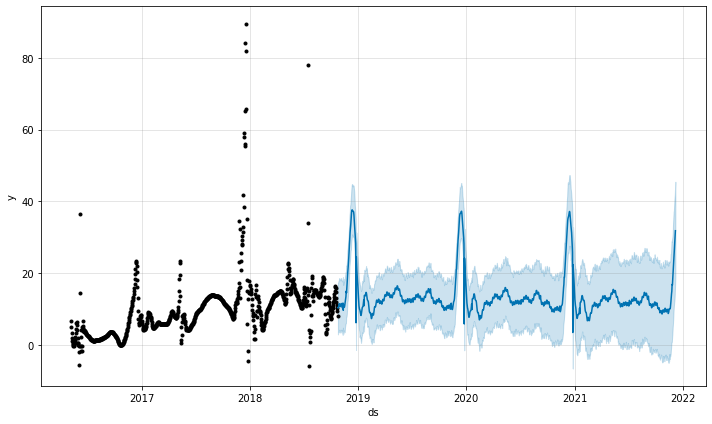

In [18]:
from fbprophet import Prophet
from pandas import to_datetime

#holidays = pd.DataFrame({
#  'holiday': 'playoff',
#  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
#                        '2010-01-24', '2010-02-07', '2011-01-08',
#                        '2013-01-12', '2014-01-12', '2014-01-19',
#                        '2014-02-02', '2015-01-11', '2016-01-17',
#                        '2016-01-24', '2016-02-07']),
#  'lower_window': 0,
#  'upper_window': 1,
#})

#model = Prophet(seasonality_mode='multiplicative') #hoiidays=holidays
model = Prophet() #hoiidays=holidays
model.add_country_holidays(country_name='US')
print("HOLIDAYS LIST:")



model.fit(df_train)
print(model.train_holiday_names)
print("")
print("Train:")
print(df_train.head(6))


future = df_test.iloc[:, 0]
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])


print("")
print("Test:")
print(future.head(6))
forecast = model.predict(future)

print("")
print("Forecast:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(6))


fig = model.plot(forecast)


In [19]:
df_var = df_z

df_var['ds'] = pd.to_datetime(df_var['ds'])
weekly_df = df_var.resample('W', on='ds').apply(sum)
monthly_df = df_var.resample('M', on='ds').apply(sum)
daily_df = df_var.resample('D', on='ds').apply(sum)
fig = go.Figure()
fig.add_traces(go.Scatter(x=pd.to_datetime(daily_df.index.values), y = daily_df['y'], mode = 'lines', line=dict(color="royalblue"), name = 'Actual Sales'))
fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat_upper'], mode = 'lines', line=dict(color="pink"), name = 'Predicted Sales (Upper Bound)'))
fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat_lower'], fill = 'tonexty', mode = 'lines', line=dict(color="pink"), name = 'Predicted Sales (Lower Bound)'))


fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat'], mode = 'lines', line=dict(color=colors[1]), name = 'Predicted Sales'))
fig.add_traces(go.Scatter(x=df_train['ds'], y = df_train['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Training data (Denoised)'))

fig.update_layout(title_text='Daily Sales Prediction for Product SKU '+product_name_x, title_x=0.5)

fig.show()

In [20]:
forecast_monthly = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
forecast_monthly.set_index('ds',inplace=True, drop=True)
forecast_monthly = forecast_monthly.resample('M').sum()
print(forecast_monthly)
df_overall_monthly = forecast_monthly.copy()
#fig = go.Figure()
#fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color="royalblue"), name = 'Actual Sales'))
#fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat_upper'], mode = 'lines', line=dict(color="pink"), name = 'Predicted Sales (Upper Bound)'))
#fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat_lower'], fill = 'tonexty', mode = 'lines', line=dict(color="pink"), name = 'Predicted Sales (Lower Bound)'))

#fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat'], mode = 'lines', line=dict(color="red"), name = 'Predicted Sales'))
#fig.add_traces(go.Scatter(x=df_train['ds'], y = df_train['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Training data'))

#fig.update_layout(title_text='Monthly Sales Prediction for Product SKU '+product_name_x, title_x=0.5)

#fig.show()

                  yhat   yhat_upper  yhat_lower
ds                                             
2018-10-31   76.030235   125.978557   25.566688
2018-11-30  401.609747   617.705575  187.415098
2018-12-31  927.689840  1151.921210  705.408331
2019-01-31  359.898709   581.443182  138.968446
2019-02-28  267.588771   466.435218   68.189186
2019-03-31  373.742455   595.161100  155.572985
2019-04-30  415.721313   632.024381  198.974615
2019-05-31  457.093830   680.653611  234.732959
2019-06-30  365.958660   580.516555  147.496089
2019-07-31  408.190438   631.958323  183.634247
2019-08-31  425.655933   649.848196  198.814534
2019-09-30  378.223342   600.139207  158.891479
2019-10-31  335.973754   568.495643  107.034056
2019-11-30  385.555948   611.375476  159.102924
2019-12-31  915.911997  1150.181637  680.225545
2020-01-31  344.889386   586.017408  107.609007
2020-02-29  265.230799   492.046101   36.545918
2020-03-31  362.387082   608.979225  116.361588
2020-04-30  401.147113   647.066127  160

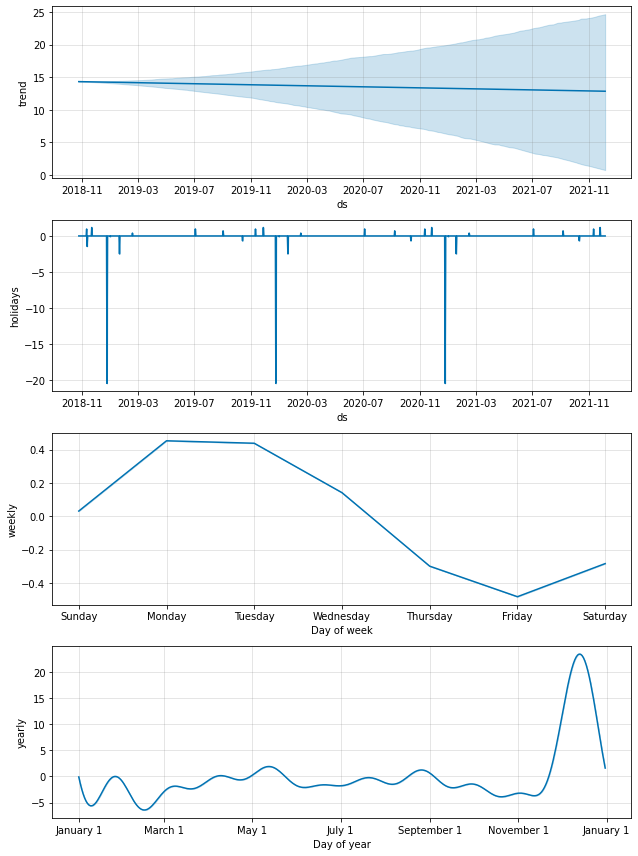

In [21]:
fig = model.plot_components(forecast)

# **Simulating Updating a Fitted Model**


In [22]:
!pip install pystan==2.19.1.1
!pip install prophet

In [23]:
!pip install kaleido


In [24]:
!pip install plotly==5.5.0

In [25]:
import pandas as pd

primeday_US = pd.DataFrame({
  'holiday': 'primeday_US',
  'ds': pd.to_datetime(['2016-07-12', '2017-07-11', '2018-07-16', '2019-07-15', '2019-07-16', '2020-07-21', '2020-07-22', '2021-07-21', '2021-07-22']),
  'lower_window': 0,
  'upper_window': 1,
})

blackfriday_US = pd.DataFrame({
  'holiday': 'blackfriday_US',
  'ds': pd.to_datetime(['2016-11-25', '2017-11-24', '2018-11-23', '2019-11-29', '2020-11-27', '2021-11-26']),
  'lower_window': 0,
  'upper_window': 1,
})

cybermonday_US = pd.DataFrame({
  'holiday': 'cybermonday_US',
  'ds': pd.to_datetime(['2016-11-28', '2017-11-27', '2018-11-26', '2019-12-02', '2020-11-30', '2021-11-29']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((primeday_US, blackfriday_US, cybermonday_US))

In [31]:
from fbprophet import Prophet
from pandas import to_datetime
from fbprophet import Prophet
import pandas as pd
import time
import numpy as np
import datetime
from datetime import datetime, timedelta
from datetime import datetime
import os
import glob
from PIL import Image
import plotly.express as px

df_z.to_csv("traindate_z.csv")
def stan_init(m):
  res = {}
  for pname in ['k', 'm', 'sigma_obs']:
    res[pname] = m.params[pname][0][0]
  for pname in ['delta', 'beta']:
    res[pname] = m.params[pname][0]
  return res

train_range_start=0   
train_range_end=900
test_range_start=900
 
first_date = test_range_start 
num_days = df_z.iloc[first_date]
print("numdays", num_days['ds'])
num_days_query = num_days['ds']
num_days = num_days_query.days_in_month
print(num_days)
days_left = (num_days_query.replace(day=1) + timedelta(days=32)).replace(day=1)
print("Days left till end of month")
days_left = days_left - num_days_query
days_left = days_left.days - 1
print(days_left)
first_date+=days_left
test_range_start = test_range_start
test_range_end=test_range_start + days_left + 1
print("Training from", df_z.iloc[train_range_start]['ds'], " to ", df_z.iloc[train_range_end]['ds'])
print("Testing from ", df_z.iloc[test_range_start + 1]['ds'], " to ", df_z.iloc[test_range_end - 1]['ds'])

df_train = df_z.iloc[train_range_start:train_range_end,:]
df_test = df_z.iloc[test_range_start:test_range_end,:]
df_test.reset_index(inplace = True, drop = True)


m1 = Prophet(changepoint_prior_scale=0.4, holidays=holidays) 


m1.add_country_holidays(country_name='US')
print(df_train)
print(df_test)
print("Fitting first time")
m1.fit(df_train)
future = df_test.iloc[:, 0]
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
forecast = m1.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(6))
forecast_monthly = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
forecast_monthly.set_index('ds',inplace=True, drop=True)
forecast_monthly = forecast_monthly.resample('M').sum()

fig = go.Figure()
fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color="royalblue"), name = 'Actual Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat_upper'], mode = 'lines+markers', marker_symbol='line-ew', marker_line_color="red", marker_color="red",
                           marker_line_width=2, marker_size=10, line=dict(color="pink"), name = 'Predicted Sales (Upper Bound)'))
fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat_lower'], mode = 'lines+markers', marker_symbol='line-ew', marker_line_color="red", marker_color="red",
                           marker_line_width=2, marker_size=10, line=dict(color="pink"), name = 'Predicted Sales (Lower Bound)'))
fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat'], mode = 'lines+markers', line=dict(color="red"), name = 'Predicted Sales'))
fig.add_traces(go.Scatter(x=df_train['ds'], y = df_train['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Training data'))

fig.update_layout(title = dict(text='Monthly Sales Prediction for Product SKU '+product_name_z,x=0.5, font =dict(size=17, color = 'white')))
fig.update_layout(xaxis = {'title':'Year', 'color':'white'}, yaxis = {'title':'Demand', 'color':'white'}, paper_bgcolor='#1c1c28', plot_bgcolor='#28293d')
fig.update_layout(legend_font_color="white")
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.update_layout(autosize=False, width=1013, height=525)
fig.show()

first_date = test_range_start
ctr=0

print("Before loop")
print(train_range_start, train_range_end, test_range_start, test_range_end)

forecast_monthly_history = pd.DataFrame(columns = ['yhat', 'yhat_upper', 'yhat_lower'])
forecast_monthly_history.index = pd.to_datetime(forecast_monthly_history.index)
print("Starting to track prediction history...")

while test_range_end + 30 <= 2039:
  train_range_end = test_range_end - 1
  test_range_start = train_range_end + 1
  num_days = df_z.iloc[test_range_start]
  num_days_query = num_days['ds']
  num_days = num_days_query.days_in_month
  print(num_days)
  test_range_end = test_range_start + num_days
  
  print("Training from", df_z.iloc[train_range_start]['ds'], " to ", df_z.iloc[train_range_end]['ds'])
  print("Testing from ", df_z.iloc[test_range_start]['ds'], " to ", df_z.iloc[test_range_end-1]['ds'])

  df_train = df_z.iloc[train_range_start:train_range_end,:]
  df_test = df_z.iloc[test_range_start:test_range_end,:]
  df_test.reset_index(inplace = True, drop = True)

  #print(df_train.tail(10))

  
  m2 = Prophet(changepoint_prior_scale=0.4, holidays=holidays)


  m2.add_country_holidays(country_name='US')
  print("Fitting second time")
  if ('02-29') not in str(df_z.iloc[test_range_end-1]['ds']):
    m2.fit(df_train, init=stan_init(m1))
    future = df_test.iloc[:, 0]
    future = pd.DataFrame(future)
    future.columns = ['ds']
    future['ds']= to_datetime(future['ds'])
    forecast = m2.predict(future)
    m1=m2
  else:
    
    
    m1 = Prophet(changepoint_prior_scale=0.4, holidays=holidays) #hoiidays=holidays


    m1.add_country_holidays(country_name='US')
    m1.fit(df_train)
    future = df_test.iloc[:, 0]
    future = pd.DataFrame(future)
    future.columns = ['ds']
    future['ds']= to_datetime(future['ds'])
    forecast = m1.predict(future)

  forecast_monthly = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
  forecast_monthly.set_index('ds',inplace=True, drop=True)
  forecast_monthly = forecast_monthly.resample('M').sum()

  if(forecast_monthly.iloc[0]['yhat'] < 0):
    forecast_monthly.iloc[0]['yhat'] = 0
  if(forecast_monthly.iloc[0]['yhat_upper']<0):
    forecast_monthly.iloc[0]['yhat_upper'] = 0
  if(forecast_monthly.iloc[0]['yhat_lower']<0):
    forecast_monthly.iloc[0]['yhat_lower'] = 0
    forecast_monthly.iloc[0]['yhat'] = (forecast_monthly.iloc[0]['yhat_lower'] + forecast_monthly.iloc[0]['yhat_upper'] ) / 2
  print(forecast_monthly)

  actual_text_date=0
  actual_text_flag = 0
  x=0
  #while actual_text_flag == 0:
  #  print(forecast_monthly.iloc[0].index.values)
  #  print(monthly_df.iloc[x].index.values)
    #if forecast_monthly.iloc[0].index == monthly_df.iloc[x].index:
    #  actual_text_date=monthly_df.iloc[x]['y'] 
    #  actual_text_flag+=1  
  #  x+=1
   #for printing actual sales
  
  fig = go.Figure()
  fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color="royalblue"), name = 'Actual Sales'))
  
  fig.add_traces(go.Scatter(x=pd.to_datetime(df_overall_monthly.index.values), y = df_overall_monthly['yhat'], mode = 'lines', line=dict(color="sandybrown"), name = 'Predicted Sales (not updating monthly)'))

  fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat_upper'], mode = 'lines+markers', marker_symbol='line-ew', marker_line_color="red", marker_color="red",
                           marker_line_width=2, marker_size=10, line=dict(color="red"), name = 'Predicted Sales Upper Limit (updated monthly)'))
  fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat_lower'], mode = 'lines+markers', marker_symbol='line-ew', marker_line_color="red", marker_color="red",
                           marker_line_width=2, marker_size=10, line=dict(color="pink"), name = 'Predicted Sales Lower Limit (updated monthly)'))


  fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat'], mode = 'lines+markers', line=dict(color="red"), name = 'Predicted Sales (updated monthly)'))
  
  fig.add_traces(go.Scatter(x=df_train['ds'], y = df_train['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Training data'))


  forecast_monthly_history = forecast_monthly_history.append(forecast_monthly)
  print(forecast_monthly_history)

  fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly_history.index.values), y = forecast_monthly_history['yhat'], mode = 'lines', line=dict(color="indianred"), name = 'History'))

  fig.update_layout(title = dict(text='Monthly Sales Prediction for Product SKU '+product_name_z,x=0.5, font =dict(size=17, color = 'white')))
  fig.update_layout(xaxis = {'title':'Year', 'color':'white'}, yaxis = {'title':'Demand', 'color':'white'}, paper_bgcolor='#1c1c28', plot_bgcolor='#28293d')
  fig.update_layout(legend_font_color="white")
  fig.update_layout(width=1013, height=525)
  fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
  fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')  
  fig.update_xaxes(rangemode="tozero")
  fig.update_yaxes(rangemode="tozero")
  

  predicted_month = forecast_monthly.index.values
  predicted_month = pd.to_datetime(predicted_month)
  predicted_month = predicted_month.strftime('%b')
  
  predicted_month = str(predicted_month)
  predicted_month = predicted_month.replace("Index(['",'')
  predicted_month = predicted_month.replace("'], dtype='object')",'')
  #predicted_month = predicted_month.astype('str')
  print(predicted_month)

  text_sales = forecast_monthly.iloc[0]['yhat']
  text_sales = "Your monthly sales prediction for " + predicted_month + " is " + str(int(text_sales)) + " (" + str(int(forecast_monthly.iloc[0]['yhat_lower'])) + " - " + str(int(forecast_monthly.iloc[0]['yhat_upper'])) + ")"
  fig.add_annotation(dict(font=dict(color='white',size=15),
                                        x=0,
                                        y=-0.15,
                                        showarrow=False,
                                        text=text_sales,
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))
  
  text_sales2 = 100
  text_sales = "Actual sales is " + str(int(text_sales2))
  fig.add_annotation(dict(font=dict(color='white',size=15),
                                        x=0,
                                        y=-0.2,
                                        showarrow=False,
                                        text=text_sales,
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))


  fig.show()
  ctr=ctr+1
  s1 = "frame_folder/fig0"
  s2 = str(ctr)
  s3 = ".png"
  s4=s1+s2+s3
  print(s4)
  fig.write_image(s4)
  if (test_range_end + 30 >= 2039):
    print("INSUFFICIENT DATA TO MAKE A MONTHLY PREDICTION")







numdays 2018-10-25 00:00:00
31
Days left till end of month
6
Training from 2016-05-08 00:00:00  to  2018-10-25 00:00:00
Testing from  2018-10-26 00:00:00  to  2018-10-31 00:00:00
            ds   y
0   2016-05-08   0
1   2016-05-09   0
2   2016-05-10   1
3   2016-05-11   0
4   2016-05-12   0
..         ...  ..
895 2018-10-20  12
896 2018-10-21  16
897 2018-10-22  18
898 2018-10-23  17
899 2018-10-24  13

[900 rows x 2 columns]
          ds   y
0 2018-10-25   9
1 2018-10-26  15
2 2018-10-27  17
3 2018-10-28  11
4 2018-10-29   8
5 2018-10-30  15
6 2018-10-31   6
Fitting first time


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       yhat  yhat_lower  yhat_upper
0 2018-10-25  10.971541    3.552753   18.932542
1 2018-10-26  11.039188    3.270864   19.533676
2 2018-10-27  10.325773    1.668503   18.273455
3 2018-10-28  11.651845    3.135420   19.736524
4 2018-10-29  13.439839    5.296500   21.431028
5 2018-10-30  13.630032    5.372209   21.984646


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Before loop
0 900 900 907
Starting to track prediction history...
30
Training from 2016-05-08 00:00:00  to  2018-10-31 00:00:00
Testing from  2018-11-01 00:00:00  to  2018-11-30 00:00:00
Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2018-11-30  417.435176  662.745005  171.556851
                  yhat  yhat_upper  yhat_lower
2018-11-30  417.435176  662.745005  171.556851
Nov


frame_folder/fig01.png
31
Training from 2016-05-08 00:00:00  to  2018-11-30 00:00:00
Testing from  2018-12-01 00:00:00  to  2018-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2018-12-31  1250.979044  1548.055784  951.168241
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
Dec


frame_folder/fig02.png
31
Training from 2016-05-08 00:00:00  to  2018-12-31 00:00:00
Testing from  2019-01-01 00:00:00  to  2019-01-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat   yhat_upper  yhat_lower
ds                                             
2019-01-31  723.350606  1099.478606  354.398873
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
Jan


frame_folder/fig03.png


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


28
Training from 2016-05-08 00:00:00  to  2019-01-31 00:00:00
Testing from  2019-02-01 00:00:00  to  2019-02-28 00:00:00
Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-02-28  487.100751  827.672944  146.725088
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
Feb


frame_folder/fig04.png
31
Training from 2016-05-08 00:00:00  to  2019-02-28 00:00:00
Testing from  2019-03-01 00:00:00  to  2019-03-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-03-31  603.270349  974.119663  230.565133
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
Mar


frame_folder/fig05.png
30
Training from 2016-05-08 00:00:00  to  2019-03-31 00:00:00
Testing from  2019-04-01 00:00:00  to  2019-04-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-04-30  619.053483  979.175923  260.866114
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
Apr


frame_folder/fig06.png
31
Training from 2016-05-08 00:00:00  to  2019-04-30 00:00:00
Testing from  2019-05-01 00:00:00 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 to  2019-05-31 00:00:00
Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-05-31  562.634193  934.306912  195.133205
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
2019-05-31   562.634193   934.306912  195.133205
May


frame_folder/fig07.png
30
Training from 2016-05-08 00:00:00  to  2019-05-31 00:00:00
Testing from  2019-06-01 00:00:00  to  2019-06-30 00:00:00
Fitting second time


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                  yhat  yhat_upper  yhat_lower
ds                                            
2019-06-30  343.149985  686.299971         0.0
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
2019-05-31   562.634193   934.306912  195.133205
2019-06-30   343.149985   686.299971    0.000000
Jun


frame_folder/fig08.png
31
Training from 2016-05-08 00:00:00  to  2019-06-30 00:00:00
Testing from  2019-07-01 00:00:00  to  2019-07-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-07-31  331.800023  663.600045         0.0
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
2019-05-31   562.634193   934.306912  195.133205
2019-06-30   343.149985   686.299971    0.000000
2019-07-31   331.800023   663.600045    0.000000
Jul


frame_folder/fig09.png
31
Training from 2016-05-08 00:00:00  to  2019-07-31 00:00:00
Testing from  2019-08-01 00:00:00  to  2019-08-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-08-31  304.851793  609.703587         0.0
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
2019-05-31   562.634193   934.306912  195.133205
2019-06-30   343.149985   686.299971    0.000000
2019-07-31   331.800023   663.600045    0.000000
2019-08-31   304.851793   609.703587    0.000000
Aug


frame_folder/fig010.png
30
Training from 2016-05-08 00:00:00  to  2019-08-31 00:00:00
Testing from  2019-09-01 00:00:00  to  2019-09-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-09-30  251.995598  503.991196         0.0
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
2019-05-31   562.634193   934.306912  195.133205
2019-06-30   343.149985   686.299971    0.000000
2019-07-31   331.800023   663.600045    0.000000
2019-08-31   304.851793   609.703587    0.000000
2019-09-30   251.995598   503.991196    0.000000
Sep


frame_folder/fig011.png
31
Training from 2016-05-08 00:00:00  to  2019-09-30 00:00:00
Testing from  2019-10-01 00:00:00  to  2019-10-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-10-31  260.069295   520.13859         0.0
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
2019-05-31   562.634193   934.306912  195.133205
2019-06-30   343.149985   686.299971    0.000000
2019-07-31   331.800023   663.600045    0.000000
2019-08-31   304.851793   609.703587    0.000000
2019-09-30   251.995598   503.991196    0.000000
2019-10-31   260.069295   520.138590    0.000000
Oct


frame_folder/fig012.png
30
Training from 2016-05-08 00:00:00  to  2019-10-31 00:00:00
Testing from  2019-11-01 00:00:00  to  2019-11-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-11-30  459.688559  790.696918  126.037236
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
2019-05-31   562.634193   934.306912  195.133205
2019-06-30   343.149985   686.299971    0.000000
2019-07-31   331.800023   663.600045    0.000000
2019-08-31   304.851793   609.703587    0.000000
2019-09-30   251.995598   503.991196    0.000000
2019-10-31   260.069295   520.138590    0.000000
2019-11-30   459.688559   790.696918  126.037236
Nov


frame_folder/fig013.png
31
Training from 2016-05-08 00:00:00  to  2019-11-30 00:00:00
Testing from  2019-12-01 00:00:00  to  2019-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2019-12-31  1279.236032  1661.868223  894.487117
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
2019-05-31   562.634193   934.306912  195.133205
2019-06-30   343.149985   686.299971    0.000000
2019-07-31   331.800023   663.600045    0.000000
2019-08-31   304.851793   609.703587    0.000000
2019-09-30   251.995598   503.991196    0.000000
2019-10-31   260.069295   520.138590    0.000000
2019-11-30   459.688559   790.696918  126.037236
2019-12-31  1279.236032  1661.868223  894.487117
Dec


frame_folder/fig014.png
31
Training from 2016-05-08 00:00:00  to  2019-12-31 00:00:00
Testing from  2020-01-01 00:00:00  to  2020-01-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat   yhat_upper  yhat_lower
ds                                             
2020-01-31  912.085677  1342.606377   474.87662
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
2019-05-31   562.634193   934.306912  195.133205
2019-06-30   343.149985   686.299971    0.000000
2019-07-31   331.800023   663.600045    0.000000
2019-08-31   304.851793   609.703587    0.000000
2019-09-30   251.995598   503.991196    0.000000
2019-10-31   260.069295   520.138590    0.000000
2019-11-30   459.688559   790.696918  126.037236
2019-12-31  1279.236032  1661.868223  894.487117
2020-01-31   912.085677  1342.606377  474.876620
Jan


frame_folder/fig015.png
29
Training from 2016-05-08 00:00:00  to  2020-01-31 00:00:00
Testing from  2020-02-01 00:00:00  to  2020-02-29 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat   yhat_upper  yhat_lower
ds                                             
2020-02-29  693.395964  1110.618389  275.814866
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
2019-05-31   562.634193   934.306912  195.133205
2019-06-30   343.149985   686.299971    0.000000
2019-07-31   331.800023   663.600045    0.000000
2019-08-31   304.851793   609.703587    0.000000
2019-09-30   251.995598   503.991196    0.000000
2019-10-31   260.069295   520.138590    0.000000
2019-11-30   459.688559   790.696918  126.037236
2019-12-31  1279.236032  1661.868223  894.487117
2020-01-31   912.085677  1342.606377  474.876620
2020-02-29   693.395964  1110.618389  275.814866
Feb

frame_folder/fig016.png
31
Training from 2016-05-08 00:00:00  to  2020-02-29 00:00:00
Testing from  2020-03-01 00:00:00  to  2020-03-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat   yhat_upper  yhat_lower
ds                                             
2020-03-31  794.213038  1234.136519  351.096384
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
2019-05-31   562.634193   934.306912  195.133205
2019-06-30   343.149985   686.299971    0.000000
2019-07-31   331.800023   663.600045    0.000000
2019-08-31   304.851793   609.703587    0.000000
2019-09-30   251.995598   503.991196    0.000000
2019-10-31   260.069295   520.138590    0.000000
2019-11-30   459.688559   790.696918  126.037236
2019-12-31  1279.236032  1661.868223  894.487117
2020-01-31   912.085677  1342.606377  474.876620
2020-02-29   693.395964  1110.618389  275.814866
202

frame_folder/fig017.png
30
Training from 2016-05-08 00:00:00  to  2020-03-31 00:00:00
Testing from  2020-04-01 00:00:00  to  2020-04-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat   yhat_upper  yhat_lower
ds                                             
2020-04-30  693.069581  1124.611781  260.135684
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
2019-05-31   562.634193   934.306912  195.133205
2019-06-30   343.149985   686.299971    0.000000
2019-07-31   331.800023   663.600045    0.000000
2019-08-31   304.851793   609.703587    0.000000
2019-09-30   251.995598   503.991196    0.000000
2019-10-31   260.069295   520.138590    0.000000
2019-11-30   459.688559   790.696918  126.037236
2019-12-31  1279.236032  1661.868223  894.487117
2020-01-31   912.085677  1342.606377  474.876620
2020-02-29   693.395964  1110.618389  275.814866
202

frame_folder/fig018.png
31
Training from 2016-05-08 00:00:00  to  2020-04-30 00:00:00
Testing from  2020-05-01 00:00:00  to  2020-05-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat   yhat_upper  yhat_lower
ds                                             
2020-05-31  970.304809  1423.045185  520.336029
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
2019-05-31   562.634193   934.306912  195.133205
2019-06-30   343.149985   686.299971    0.000000
2019-07-31   331.800023   663.600045    0.000000
2019-08-31   304.851793   609.703587    0.000000
2019-09-30   251.995598   503.991196    0.000000
2019-10-31   260.069295   520.138590    0.000000
2019-11-30   459.688559   790.696918  126.037236
2019-12-31  1279.236032  1661.868223  894.487117
2020-01-31   912.085677  1342.606377  474.876620
2020-02-29   693.395964  1110.618389  275.814866
202

frame_folder/fig019.png
30
Training from 2016-05-08 00:00:00  to  2020-05-31 00:00:00
Testing from  2020-06-01 00:00:00  to  2020-06-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2020-06-30  1059.776058  1506.940888  610.271796
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
2019-05-31   562.634193   934.306912  195.133205
2019-06-30   343.149985   686.299971    0.000000
2019-07-31   331.800023   663.600045    0.000000
2019-08-31   304.851793   609.703587    0.000000
2019-09-30   251.995598   503.991196    0.000000
2019-10-31   260.069295   520.138590    0.000000
2019-11-30   459.688559   790.696918  126.037236
2019-12-31  1279.236032  1661.868223  894.487117
2020-01-31   912.085677  1342.606377  474.876620
2020-02-29   693.395964  1110.618389  275.814866


frame_folder/fig020.png
31
Training from 2016-05-08 00:00:00  to  2020-06-30 00:00:00
Testing from  2020-07-01 00:00:00  to  2020-07-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2020-07-31  1366.598268  1825.164373  912.646115
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
2019-05-31   562.634193   934.306912  195.133205
2019-06-30   343.149985   686.299971    0.000000
2019-07-31   331.800023   663.600045    0.000000
2019-08-31   304.851793   609.703587    0.000000
2019-09-30   251.995598   503.991196    0.000000
2019-10-31   260.069295   520.138590    0.000000
2019-11-30   459.688559   790.696918  126.037236
2019-12-31  1279.236032  1661.868223  894.487117
2020-01-31   912.085677  1342.606377  474.876620
2020-02-29   693.395964  1110.618389  275.814866


frame_folder/fig021.png
31
Training from 2016-05-08 00:00:00  to  2020-07-31 00:00:00
Testing from  2020-08-01 00:00:00  to  2020-08-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2020-08-31  1400.755238  1863.560429   945.50252
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
2019-05-31   562.634193   934.306912  195.133205
2019-06-30   343.149985   686.299971    0.000000
2019-07-31   331.800023   663.600045    0.000000
2019-08-31   304.851793   609.703587    0.000000
2019-09-30   251.995598   503.991196    0.000000
2019-10-31   260.069295   520.138590    0.000000
2019-11-30   459.688559   790.696918  126.037236
2019-12-31  1279.236032  1661.868223  894.487117
2020-01-31   912.085677  1342.606377  474.876620
2020-02-29   693.395964  1110.618389  275.814866


frame_folder/fig022.png
30
Training from 2016-05-08 00:00:00  to  2020-08-31 00:00:00
Testing from  2020-09-01 00:00:00  to  2020-09-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat   yhat_upper  yhat_lower
ds                                             
2020-09-30  1343.19341  1786.761167  901.926667
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
2019-05-31   562.634193   934.306912  195.133205
2019-06-30   343.149985   686.299971    0.000000
2019-07-31   331.800023   663.600045    0.000000
2019-08-31   304.851793   609.703587    0.000000
2019-09-30   251.995598   503.991196    0.000000
2019-10-31   260.069295   520.138590    0.000000
2019-11-30   459.688559   790.696918  126.037236
2019-12-31  1279.236032  1661.868223  894.487117
2020-01-31   912.085677  1342.606377  474.876620
2020-02-29   693.395964  1110.618389  275.814866
202

frame_folder/fig023.png
31
Training from 2016-05-08 00:00:00  to  2020-09-30 00:00:00
Testing from  2020-10-01 00:00:00  to  2020-10-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat   yhat_upper  yhat_lower
ds                                             
2020-10-31  1411.55302  1868.220771  953.912526
                   yhat   yhat_upper  yhat_lower
2018-11-30   417.435176   662.745005  171.556851
2018-12-31  1250.979044  1548.055784  951.168241
2019-01-31   723.350606  1099.478606  354.398873
2019-02-28   487.100751   827.672944  146.725088
2019-03-31   603.270349   974.119663  230.565133
2019-04-30   619.053483   979.175923  260.866114
2019-05-31   562.634193   934.306912  195.133205
2019-06-30   343.149985   686.299971    0.000000
2019-07-31   331.800023   663.600045    0.000000
2019-08-31   304.851793   609.703587    0.000000
2019-09-30   251.995598   503.991196    0.000000
2019-10-31   260.069295   520.138590    0.000000
2019-11-30   459.688559   790.696918  126.037236
2019-12-31  1279.236032  1661.868223  894.487117
2020-01-31   912.085677  1342.606377  474.876620
2020-02-29   693.395964  1110.618389  275.814866
202

frame_folder/fig024.png
30
Training from 2016-05-08 00:00:00  to  2020-10-31 00:00:00
Testing from  2020-11-01 00:00:00  to  2020-11-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2020-11-30  1871.221907  2306.095278  1421.683384
                   yhat   yhat_upper   yhat_lower
2018-11-30   417.435176   662.745005   171.556851
2018-12-31  1250.979044  1548.055784   951.168241
2019-01-31   723.350606  1099.478606   354.398873
2019-02-28   487.100751   827.672944   146.725088
2019-03-31   603.270349   974.119663   230.565133
2019-04-30   619.053483   979.175923   260.866114
2019-05-31   562.634193   934.306912   195.133205
2019-06-30   343.149985   686.299971     0.000000
2019-07-31   331.800023   663.600045     0.000000
2019-08-31   304.851793   609.703587     0.000000
2019-09-30   251.995598   503.991196     0.000000
2019-10-31   260.069295   520.138590     0.000000
2019-11-30   459.688559   790.696918   126.037236
2019-12-31  1279.236032  1661.868223   894.487117
2020-01-31   912.085677  1342.606377   474.876620
2020-02-29   693.395964  1110.

frame_folder/fig025.png
31
Training from 2016-05-08 00:00:00  to  2020-11-30 00:00:00
Testing from 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 2020-12-01 00:00:00  to  2020-12-31 00:00:00
Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2020-12-31  2556.671679  3032.424441  2074.432373
                   yhat   yhat_upper   yhat_lower
2018-11-30   417.435176   662.745005   171.556851
2018-12-31  1250.979044  1548.055784   951.168241
2019-01-31   723.350606  1099.478606   354.398873
2019-02-28   487.100751   827.672944   146.725088
2019-03-31   603.270349   974.119663   230.565133
2019-04-30   619.053483   979.175923   260.866114
2019-05-31   562.634193   934.306912   195.133205
2019-06-30   343.149985   686.299971     0.000000
2019-07-31   331.800023   663.600045     0.000000
2019-08-31   304.851793   609.703587     0.000000
2019-09-30   251.995598   503.991196     0.000000
2019-10-31   260.069295   520.138590     0.000000
2019-11-30   459.688559   790.696918   126.037236
2019-12-31  1279.236032  1661.868223   894.487117
2020-01-31   912.085677  1342.6063

frame_folder/fig026.png
31
Training from 2016-05-08 00:00:00  to  2020-12-31 00:00:00
Testing from  2021-01-01 00:00:00  to  2021-01-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2021-01-31  2215.910093  2916.872573  1505.376537
                   yhat   yhat_upper   yhat_lower
2018-11-30   417.435176   662.745005   171.556851
2018-12-31  1250.979044  1548.055784   951.168241
2019-01-31   723.350606  1099.478606   354.398873
2019-02-28   487.100751   827.672944   146.725088
2019-03-31   603.270349   974.119663   230.565133
2019-04-30   619.053483   979.175923   260.866114
2019-05-31   562.634193   934.306912   195.133205
2019-06-30   343.149985   686.299971     0.000000
2019-07-31   331.800023   663.600045     0.000000
2019-08-31   304.851793   609.703587     0.000000
2019-09-30   251.995598   503.991196     0.000000
2019-10-31   260.069295   520.138590     0.000000
2019-11-30   459.688559   790.696918   126.037236
2019-12-31  1279.236032  1661.868223   894.487117
2020-01-31   912.085677  1342.606377   474.876620
2020-02-29   693.395964  1110.

frame_folder/fig027.png
28
Training from 2016-05-08 00:00:00  to  2021-01-31 00:00:00
Testing from  2021-02-01 00:00:00  to  2021-02-28 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2021-02-28  1943.033249  2590.881149  1294.31449
                   yhat   yhat_upper   yhat_lower
2018-11-30   417.435176   662.745005   171.556851
2018-12-31  1250.979044  1548.055784   951.168241
2019-01-31   723.350606  1099.478606   354.398873
2019-02-28   487.100751   827.672944   146.725088
2019-03-31   603.270349   974.119663   230.565133
2019-04-30   619.053483   979.175923   260.866114
2019-05-31   562.634193   934.306912   195.133205
2019-06-30   343.149985   686.299971     0.000000
2019-07-31   331.800023   663.600045     0.000000
2019-08-31   304.851793   609.703587     0.000000
2019-09-30   251.995598   503.991196     0.000000
2019-10-31   260.069295   520.138590     0.000000
2019-11-30   459.688559   790.696918   126.037236
2019-12-31  1279.236032  1661.868223   894.487117
2020-01-31   912.085677  1342.606377   474.876620
2020-02-29   693.395964  1110.618

frame_folder/fig028.png
31
Training from 2016-05-08 00:00:00  to  2021-02-28 00:00:00
Testing from  2021-03-01 00:00:00  to  2021-03-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2021-03-31  1999.820795  2733.627646  1275.798959
                   yhat   yhat_upper   yhat_lower
2018-11-30   417.435176   662.745005   171.556851
2018-12-31  1250.979044  1548.055784   951.168241
2019-01-31   723.350606  1099.478606   354.398873
2019-02-28   487.100751   827.672944   146.725088
2019-03-31   603.270349   974.119663   230.565133
2019-04-30   619.053483   979.175923   260.866114
2019-05-31   562.634193   934.306912   195.133205
2019-06-30   343.149985   686.299971     0.000000
2019-07-31   331.800023   663.600045     0.000000
2019-08-31   304.851793   609.703587     0.000000
2019-09-30   251.995598   503.991196     0.000000
2019-10-31   260.069295   520.138590     0.000000
2019-11-30   459.688559   790.696918   126.037236
2019-12-31  1279.236032  1661.868223   894.487117
2020-01-31   912.085677  1342.606377   474.876620
2020-02-29   693.395964  1110.

frame_folder/fig029.png


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


30
Training from 2016-05-08 00:00:00  to  2021-03-31 00:00:00
Testing from  2021-04-01 00:00:00  to  2021-04-30 00:00:00
Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2021-04-30  2084.465597  2784.836465  1375.565317
                   yhat   yhat_upper   yhat_lower
2018-11-30   417.435176   662.745005   171.556851
2018-12-31  1250.979044  1548.055784   951.168241
2019-01-31   723.350606  1099.478606   354.398873
2019-02-28   487.100751   827.672944   146.725088
2019-03-31   603.270349   974.119663   230.565133
2019-04-30   619.053483   979.175923   260.866114
2019-05-31   562.634193   934.306912   195.133205
2019-06-30   343.149985   686.299971     0.000000
2019-07-31   331.800023   663.600045     0.000000
2019-08-31   304.851793   609.703587     0.000000
2019-09-30   251.995598   503.991196     0.000000
2019-10-31   260.069295   520.138590     0.000000
2019-11-30   459.688559   790.696918   126.037236
2019-12-3

frame_folder/fig030.png
31
Training from 2016-05-08 00:00:00  to  2021-04-30 00:00:00
Testing from  2021-05-01 00:00:00  to  2021-05-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2021-05-31  2025.271301  2766.292493  1295.383094
                   yhat   yhat_upper   yhat_lower
2018-11-30   417.435176   662.745005   171.556851
2018-12-31  1250.979044  1548.055784   951.168241
2019-01-31   723.350606  1099.478606   354.398873
2019-02-28   487.100751   827.672944   146.725088
2019-03-31   603.270349   974.119663   230.565133
2019-04-30   619.053483   979.175923   260.866114
2019-05-31   562.634193   934.306912   195.133205
2019-06-30   343.149985   686.299971     0.000000
2019-07-31   331.800023   663.600045     0.000000
2019-08-31   304.851793   609.703587     0.000000
2019-09-30   251.995598   503.991196     0.000000
2019-10-31   260.069295   520.138590     0.000000
2019-11-30   459.688559   790.696918   126.037236
2019-12-31  1279.236032  1661.868223   894.487117
2020-01-31   912.085677  1342.606377   474.876620
2020-02-29   693.395964  1110.

frame_folder/fig031.png
30
Training from 2016-05-08 00:00:00  to  2021-05-31 00:00:00
Testing from  2021-06-01 00:00:00  to  2021-06-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2021-06-30  1740.460521  2462.393579  1022.645902
                   yhat   yhat_upper   yhat_lower
2018-11-30   417.435176   662.745005   171.556851
2018-12-31  1250.979044  1548.055784   951.168241
2019-01-31   723.350606  1099.478606   354.398873
2019-02-28   487.100751   827.672944   146.725088
2019-03-31   603.270349   974.119663   230.565133
2019-04-30   619.053483   979.175923   260.866114
2019-05-31   562.634193   934.306912   195.133205
2019-06-30   343.149985   686.299971     0.000000
2019-07-31   331.800023   663.600045     0.000000
2019-08-31   304.851793   609.703587     0.000000
2019-09-30   251.995598   503.991196     0.000000
2019-10-31   260.069295   520.138590     0.000000
2019-11-30   459.688559   790.696918   126.037236
2019-12-31  1279.236032  1661.868223   894.487117
2020-01-31   912.085677  1342.606377   474.876620
2020-02-29   693.395964  1110.

frame_folder/fig032.png
31
Training from 2016-05-08 00:00:00  to  2021-06-30 00:00:00
Testing from  2021-07-01 00:00:00  to  2021-07-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat  yhat_upper  yhat_lower
ds                                             
2021-07-31  1529.889383  2267.34986  792.214882
                   yhat   yhat_upper   yhat_lower
2018-11-30   417.435176   662.745005   171.556851
2018-12-31  1250.979044  1548.055784   951.168241
2019-01-31   723.350606  1099.478606   354.398873
2019-02-28   487.100751   827.672944   146.725088
2019-03-31   603.270349   974.119663   230.565133
2019-04-30   619.053483   979.175923   260.866114
2019-05-31   562.634193   934.306912   195.133205
2019-06-30   343.149985   686.299971     0.000000
2019-07-31   331.800023   663.600045     0.000000
2019-08-31   304.851793   609.703587     0.000000
2019-09-30   251.995598   503.991196     0.000000
2019-10-31   260.069295   520.138590     0.000000
2019-11-30   459.688559   790.696918   126.037236
2019-12-31  1279.236032  1661.868223   894.487117
2020-01-31   912.085677  1342.606377   474.876620
2020-02-29   693.395964  1110.618389

frame_folder/fig033.png
31
Training from 2016-05-08 00:00:00  to  2021-07-31 00:00:00
Testing from  2021-08-01 00:00:00  to  2021-08-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2021-08-31  1206.515311  1956.797166  462.259851
                   yhat   yhat_upper   yhat_lower
2018-11-30   417.435176   662.745005   171.556851
2018-12-31  1250.979044  1548.055784   951.168241
2019-01-31   723.350606  1099.478606   354.398873
2019-02-28   487.100751   827.672944   146.725088
2019-03-31   603.270349   974.119663   230.565133
2019-04-30   619.053483   979.175923   260.866114
2019-05-31   562.634193   934.306912   195.133205
2019-06-30   343.149985   686.299971     0.000000
2019-07-31   331.800023   663.600045     0.000000
2019-08-31   304.851793   609.703587     0.000000
2019-09-30   251.995598   503.991196     0.000000
2019-10-31   260.069295   520.138590     0.000000
2019-11-30   459.688559   790.696918   126.037236
2019-12-31  1279.236032  1661.868223   894.487117
2020-01-31   912.085677  1342.606377   474.876620
2020-02-29   693.395964  1110.618

frame_folder/fig034.png
30
Training from 2016-05-08 00:00:00  to  2021-08-31 00:00:00
Testing from  2021-09-01 00:00:00  to  2021-09-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat   yhat_upper  yhat_lower
ds                                             
2021-09-30  936.598991  1659.118523   224.68675
                   yhat   yhat_upper   yhat_lower
2018-11-30   417.435176   662.745005   171.556851
2018-12-31  1250.979044  1548.055784   951.168241
2019-01-31   723.350606  1099.478606   354.398873
2019-02-28   487.100751   827.672944   146.725088
2019-03-31   603.270349   974.119663   230.565133
2019-04-30   619.053483   979.175923   260.866114
2019-05-31   562.634193   934.306912   195.133205
2019-06-30   343.149985   686.299971     0.000000
2019-07-31   331.800023   663.600045     0.000000
2019-08-31   304.851793   609.703587     0.000000
2019-09-30   251.995598   503.991196     0.000000
2019-10-31   260.069295   520.138590     0.000000
2019-11-30   459.688559   790.696918   126.037236
2019-12-31  1279.236032  1661.868223   894.487117
2020-01-31   912.085677  1342.606377   474.876620
2020-02-29   693.395964  1110.618389

frame_folder/fig035.png


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


31
Training from 2016-05-08 00:00:00  to  2021-09-30 00:00:00
Testing from  2021-10-01 00:00:00  to  2021-10-31 00:00:00
Fitting second time
                 yhat  yhat_upper  yhat_lower
ds                                           
2021-10-31  697.16903  1394.33806         0.0
                   yhat   yhat_upper   yhat_lower
2018-11-30   417.435176   662.745005   171.556851
2018-12-31  1250.979044  1548.055784   951.168241
2019-01-31   723.350606  1099.478606   354.398873
2019-02-28   487.100751   827.672944   146.725088
2019-03-31   603.270349   974.119663   230.565133
2019-04-30   619.053483   979.175923   260.866114
2019-05-31   562.634193   934.306912   195.133205
2019-06-30   343.149985   686.299971     0.000000
2019-07-31   331.800023   663.600045     0.000000
2019-08-31   304.851793   609.703587     0.000000
2019-09-30   251.995598   503.991196     0.000000
2019-10-31   260.069295   520.138590     0.000000
2019-11-30   459.688559   790.696918   126.037236
2019-12-31  1279.2360

frame_folder/fig036.png
30
Training from 2016-05-08 00:00:00  to  2021-10-31 00:00:00
Testing from  2021-11-01 00:00:00  to  2021-11-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2021-11-30  1150.417828  1844.114173  448.054332
                   yhat   yhat_upper   yhat_lower
2018-11-30   417.435176   662.745005   171.556851
2018-12-31  1250.979044  1548.055784   951.168241
2019-01-31   723.350606  1099.478606   354.398873
2019-02-28   487.100751   827.672944   146.725088
2019-03-31   603.270349   974.119663   230.565133
2019-04-30   619.053483   979.175923   260.866114
2019-05-31   562.634193   934.306912   195.133205
2019-06-30   343.149985   686.299971     0.000000
2019-07-31   331.800023   663.600045     0.000000
2019-08-31   304.851793   609.703587     0.000000
2019-09-30   251.995598   503.991196     0.000000
2019-10-31   260.069295   520.138590     0.000000
2019-11-30   459.688559   790.696918   126.037236
2019-12-31  1279.236032  1661.868223   894.487117
2020-01-31   912.085677  1342.606377   474.876620
2020-02-29   693.395964  1110.618

frame_folder/fig037.png
INSUFFICIENT DATA TO MAKE A MONTHLY PREDICTION


In [27]:
!pip freeze > requirements.txt


In [28]:
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save("results_6.gif", format="GIF", append_images=frames,
               save_all=True, duration=1000, loop=0)
    
make_gif("frame_folder")

In [29]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter(
        df, x="sepal_width", y="sepal_length", color="species"
)
fig.write_image("fig.png")

In [30]:
!pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl